In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt

import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_2par as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D, HandlerPatch

def reset_matplotlib():
    # Reset all matplotlib settings to defaults
    mpl.rcdefaults()

    # Create a default handler map and update it globally
    default_handler_map = {
        mpl.lines.Line2D: HandlerLine2D(numpoints=1),
        mpl.patches.Patch: HandlerPatch()
    }

    # Update the default handler map globally
    mpl.legend.Legend.update_default_handler_map(default_handler_map)

# Call this function at the start of your script to globally reset settings
reset_matplotlib()

import getpass
uname = getpass.getuser()
figtype = None #"notebook"

# plt.style.use('default')
import scienceplots
if uname == 'darkknight':
    if figtype == "notebook":
        plt.style.use(['science','ieee','notebook'])
        plt.rcParams.update({'figure.dpi': 185/1.75/1.5})
    else:
        plt.style.use(['science','ieee'])
        plt.rcParams.update({'figure.dpi': 185/1.75*1.2})
elif uname == 'brian':
    if figtype == "notebook":
        plt.style.use(['science','ieee','notebook'])
        plt.rcParams.update({'figure.dpi': 185/1.75/1.5})
    else:
        plt.style.use(['science','ieee'])
        plt.rcParams.update({'figure.dpi': 254})
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.rcParams.update({'font.serif': 'Times', 'font.family' : 'serif'})


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [2]:
# Ground stuff
n_freq = 2000
fmin = 10.
fmax = 1000.
freqs = jnp.logspace(jnp.log10(fmin), jnp.log10(fmax), num = int(n_freq))


full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))

psd = lib.read_mag(freqs, "curves/o3_l1.txt")**2
# psd = lib.read_mag(freqs, "../curves/ce1.txt")**2

data_150914 = np.array(data[0])
data_150914[0] = 30
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390

idx = '150914'
if idx=='150914':
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))

In [3]:
from jimgw.detector import H1, L1, V1
from jimgw.waveform import RippleIMRPhenomPv2, RippleIMRPhenomD
import jax
import jax.numpy as jnp
from jax import grad, vmap

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
# Assuming 'waveform' is defined elsewhere, or you can import it
waveform = RippleIMRPhenomPv2(f_ref=20)
# waveform = RippleIMRPhenomD(f_ref=20)

def get_h_slow(x, f, detector):
    # Set default parameters
    

    ff = jnp.array([f])
    h_sky = waveform(ff, x)
    align_time = jnp.exp(-1j * 2 * jnp.pi * ff * (x['epoch'] + x['t_c']))
    signal = detector.fd_response(ff, h_sky, x) * align_time
    return signal[0]

def get_dh_nojit(x, f, detector):
    # Define a function to compute the real and imaginary parts
    def h_real(x, f):
        return get_h_slow(x, f, detector).real

    def h_imag(x, f):
        return get_h_slow(x, f, detector).imag

    # Compute gradients
    ur = vmap(grad(h_real), in_axes=(None, 0))(x, f)
    ui = vmap(grad(h_imag), in_axes=(None, 0))(x, f)
    dh = {key: ur.get(key, 0) + 1j * ui.get(key, 0) for key in x}
    return dh

# Create generic functions for each detector
def get_h_nojit(x, f, detector):
    return vmap(lambda f_single: get_h_slow(x, f_single, detector))(f)

# Example usage:
# For H1 detector
# h_H1 = get_h(x, f, H1)
# dh_H1 = get_dh(x, f, H1)

# # For L1 detector
# h_L1 = get_h(x, f, L1)
# dh_L1 = get_dh(x, f, L1)

# # For V1 detector
# h_V1 = get_h(x, f, V1)
# dh_V1 = get_dh(x, f, V1)
# print(dat)

red_param = dict(zip(names, jnp.array(dat).T))
epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
        red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.2

y = x.copy()
y['s1_x'] = 0.01

get_h = jax.jit(get_h_nojit, static_argnums=2)
get_dh = jax.jit(get_dh_nojit, static_argnums=2)
a = get_h(x, freqs,H1)
b = get_dh(x, freqs,H1)

In [4]:
red_param = dict(zip(names, jnp.array(dat).T))
epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
        red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = jnp.array(0.4)

y = x.copy()
y['s1_x'] = jnp.array(0.5)

In [5]:
paramx = ['M_c', 'eta', 'd_L', 'ra', 'dec', 'iota', 'psi', 't_c', 'phase_c', 's1_z']
paramy = paramx+['s1_x']


log_flag =  {paramy[i] : 0 for i in range(len(paramy))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1

In [6]:
h_H1 = get_h(x, freqs,H1)
h_L1 = get_h(x, freqs,L1)
h_V1 = get_h(x, freqs,V1)

Dh_H1 = get_h(y, freqs,H1) - h_H1
Dh_L1 = get_h(y, freqs,L1) - h_L1
Dh_V1 = get_h(y, freqs,V1) - h_V1

# dephasing = jnp.exp(1j*freqs**(-5/3) * freqs**(1/3) *0.01)
# Dh_H1 = h_H1*dephasing
# Dh_L1 = h_L1*dephasing
# Dh_V1 = h_V1*dephasing

dh_H1 = get_dh(x, freqs,H1)
dh_L1 = get_dh(x, freqs,L1)
dh_V1 = get_dh(x, freqs,V1)



In [7]:
idx_x = {paramx[i] : i for i in range(len(paramx))}
fi_H1 = lib.fish(freqs, dh_H1, x, idx_x, psd, log_flag)
fi_L1 = lib.fish(freqs, dh_L1, x, idx_x, psd, log_flag)
fi_V1 = lib.fish(freqs, dh_V1, x, idx_x, psd, log_flag)
fi = fi_H1 + fi_L1 + fi_V1

#do this afterward I unfortunately already implemented it 
for i in paramx:
    if log_flag[i]:
        dh_H1[i] = dh_H1[i] * x[i]
        dh_L1[i] = dh_L1[i] * x[i]
        dh_V1[i] = dh_V1[i] * x[i]

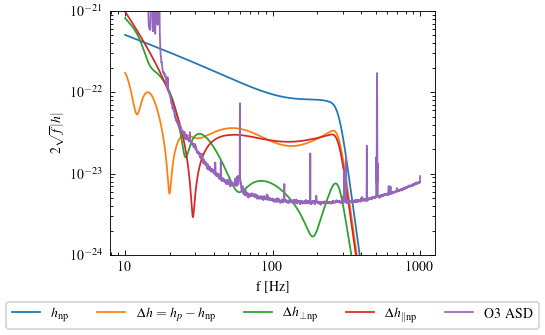

In [191]:
def compute_bias(dhdtheta, Dh, psd, freqs, idx_par):
    res = { key : jnp.real(lib.innprod(dhdtheta[key], Dh, psd, freqs)) for key in idx_par.keys()}
    bias = [res[key] for key, index in sorted(idx_par.items(), key=lambda item: item[1])]
    return jnp.real(jnp.array(bias))



V = compute_bias(dh_H1, Dh_H1, psd, freqs, idx_x) + compute_bias(dh_L1, Dh_L1, psd, freqs, idx_x) + compute_bias(dh_V1, Dh_V1, psd, freqs, idx_x)
V = np.array(V)
lam = V @ sla.inv(fi)

dh = np.array([dh_H1[s] for s in idx_x])

dhtot = Dh_H1
dhperp = (dhtot - lam @ dh)
dhpara = lam @ dh

plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(h_H1), label =r'$h_\mathrm{np}$')
plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(dhtot),label = r'$\Delta h=h_p - h_\mathrm{np}$')
plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(dhperp),label = r'$\Delta h_{\perp \mathrm{np}}$')
plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(dhpara),label = r"$\Delta h_{\parallel \mathrm{np}}$")
plt.loglog(freqs, psd**(1/2),label = "O3 ASD")
plt.xlabel('f [Hz]')
plt.ylabel('$2 \sqrt{f} |h|$')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33),ncols=5,handler_map=None,frameon=True)
plt.ylim(bottom = 1e-24,top = 1e-21)
plt.savefig(datestr + "-prec-comparison.pdf",bbox_inches='tight')
plt.show()

In [174]:
dhpH = Dh_H1- lam @ np.array([dh_H1[s] for s in idx_x])
dhpL = Dh_L1- lam @ np.array([dh_L1[s] for s in idx_x])
dhpV = Dh_V1- lam @ np.array([dh_V1[s] for s in idx_x])
snrsq = lambda h : lib.innprod(h, h, psd, freqs)

print('dh perp network snr: {:0.2f}'.format(jnp.real(snrsq(dhpH)+snrsq(dhpL)+snrsq(dhpV))**(1/2)))
print('dh orig network snr: {:0.2f}'.format(jnp.real(snrsq(Dh_H1)+snrsq(Dh_L1)+snrsq(Dh_V1))**(1/2)))
print('tot network snr: {:0.2f}'.format(jnp.real(snrsq(h_H1)+snrsq(h_L1)+snrsq(h_V1))**(1/2)))
y

dh perp network snr: 4.43
dh orig network snr: 14.51
tot network snr: 53.14


{'M_c': Array(30., dtype=float64),
 'eta': Array(0.2465591, dtype=float64),
 'd_L': Array(390., dtype=float64),
 'ra': Array(1.69254929, dtype=float64),
 'dec': Array(0.93918916, dtype=float64),
 'iota': Array(2.35481238, dtype=float64),
 'psi': Array(-1.20559143, dtype=float64),
 't_c': Array(0., dtype=float64),
 'phase_c': Array(0., dtype=float64),
 's1_x': Array(0.5, dtype=float64, weak_type=True),
 's1_y': Array(1.e-06, dtype=float64, weak_type=True),
 's1_z': Array(0.4, dtype=float64, weak_type=True),
 's2_x': Array(1.e-06, dtype=float64, weak_type=True),
 's2_y': Array(1.e-06, dtype=float64, weak_type=True),
 's2_z': Array(1.e-06, dtype=float64, weak_type=True),
 'gmst': Array(0., dtype=float64, weak_type=True),
 'epoch': Array(0., dtype=float64, weak_type=True)}